In [1]:
# # Core scientific and utility libraries
# !pip install tqdm
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install opencv-python
# !pip install pillow  # for PIL

# # PyTorch and torchvision
# !pip install torch torchvision torchaudio

# # TensorBoard
# !pip install tensorboard

# # scikit-learn for evaluation metrics
# !pip install scikit-learn
!nvidia-smi
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


Fri May  9 15:38:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8             17W /  105W |     395MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import Libraries
import time
import os
import random
import shutil
import datetime
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [15]:
# Set fixed seed for reproducibility
random.seed(42)

# Function to sample and copy images
def sample_images(source_root, target_root, num_samples):
    # Clear target directory if it exists
    if os.path.exists(target_root):
        shutil.rmtree(target_root)
    os.makedirs(target_root)

    # Loop over subfolders
    for class_name in os.listdir(source_root):
        class_path = os.path.join(source_root, class_name)

        if os.path.isdir(class_path):
            # Create matching subfolder in target
            target_class_path = os.path.join(target_root, class_name)
            os.makedirs(target_class_path, exist_ok=True)

            # List image files
            image_files = [f for f in os.listdir(class_path)
                           if os.path.isfile(os.path.join(class_path, f))]

            # Select samples (check size just in case)
            if len(image_files) < num_samples:
                raise ValueError(f"Not enough images in {class_path} to sample {num_samples}.")

            selected_images = random.sample(image_files, num_samples)

            # Copy images
            for image in selected_images:
                src_path = os.path.join(class_path, image)
                dst_path = os.path.join(target_class_path, image)
                shutil.copy(src_path, dst_path)

# Apply to Training
sample_images('preprocess_skull_strip/Training', 'preprocess_skull_strip/Training', num_samples=10)

# Apply to Testing
sample_images('preprocess_skull_strip/Testing', 'preprocess_skull_strip/Testing', num_samples=2)

print("Sampling complete for both Training and Testing.")

Sampling complete for both Training and Testing.


In [3]:
# Configuration
image_size = 200
batch_size = 64
num_epochs = 50
learning_rate = 1e-4
patience = 5  # for early stopping

train_dir = 'preprocess_skull_strip/Training'
test_dir = 'preprocess_skull_strip/Testing'
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [5]:
# Custom Dataset
def is_image_file(fname):
    return any(fname.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg', '.bmp'])

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.samples = []
        self.labels_map = {label: idx for idx, label in enumerate(labels)}
        self.transform = transform
        for label in labels:
            dir_path = os.path.join(root_dir, label)
            for fname in os.listdir(dir_path):
                if is_image_file(fname):
                    self.samples.append((os.path.join(dir_path, fname), self.labels_map[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Prepare Datasets and DataLoaders
full_train_ds = BrainTumorDataset(train_dir, labels, transform=train_transforms)
train_size = int(0.75 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_ds.dataset.transform = val_transforms

test_ds = BrainTumorDataset(test_dir, labels, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
# Model Definition
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, len(labels))
)
model = model.to(device)

In [8]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5)

# TensorBoard Setup
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

# Utility: Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    return figure

In [9]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

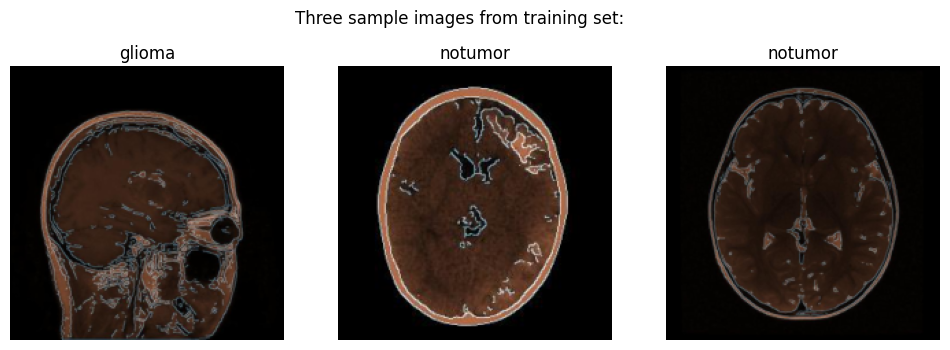

In [10]:
# Display sample images
num_samples = 3
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*4, 4))
for i in range(num_samples):
    img_tensor, lbl = train_ds[i]
    img = img_tensor * 0.5 + 0.5  # unnormalize
    img = img.permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(labels[lbl])
    axes[i].axis('off')
plt.suptitle('Three sample images from training set:')
plt.show()

In [11]:
# Training Loop with Early Stopping and Checkpointing
best_val_loss = float('inf')
no_improve_epochs = 0

# Keep track of metrics for plotting
train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, running_corrects, total_samples = 0.0, 0, 0
    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == targets.data)
        total_samples += inputs.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = running_corrects.double() / total_samples

    # Validation phase
    model.eval()
    val_loss, val_corrects, val_samples = 0.0, 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_samples += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_val_loss = val_loss / val_samples
    epoch_val_acc = val_corrects.double() / val_samples

    # Step scheduler
    scheduler.step(epoch_val_loss)

    # Record metrics for plotting
    train_losses_list.append(epoch_train_loss)
    val_losses_list.append(epoch_val_loss)
    train_accs_list.append(epoch_train_acc.item())
    val_accs_list.append(epoch_val_acc.item())

    # TensorBoard logging
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_train_acc, epoch)
    writer.add_scalar('Accuracy/val', epoch_val_acc, epoch)
    cm = confusion_matrix(all_targets, all_preds)
    fig = plot_confusion_matrix(cm, labels)
    writer.add_figure('Confusion Matrix', fig, epoch)

    # Checkpoint & Early Stopping
    if epoch_val_loss < best_val_loss - 0.001:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

Validating Epoch 1: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.17s/it]


Epoch 1/50, Train Loss: 0.3297, Val Loss: 0.1382, Train Acc: 0.8746, Val Acc: 0.9524


Validating Epoch 2: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.56it/s]


Epoch 2/50, Train Loss: 0.0571, Val Loss: 0.0729, Train Acc: 0.9839, Val Acc: 0.9741


Validating Epoch 3: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.64it/s]


Epoch 3/50, Train Loss: 0.0187, Val Loss: 0.1229, Train Acc: 0.9944, Val Acc: 0.9615


Validating Epoch 4: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.64it/s]


Epoch 4/50, Train Loss: 0.0079, Val Loss: 0.0829, Train Acc: 0.9991, Val Acc: 0.9748


Validating Epoch 5: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.66it/s]


Epoch 5/50, Train Loss: 0.0041, Val Loss: 0.0690, Train Acc: 0.9998, Val Acc: 0.9790


Validating Epoch 6: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.69it/s]


Epoch 6/50, Train Loss: 0.0019, Val Loss: 0.0744, Train Acc: 1.0000, Val Acc: 0.9790


Validating Epoch 7: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.67it/s]


Epoch 7/50, Train Loss: 0.0160, Val Loss: 0.1790, Train Acc: 0.9956, Val Acc: 0.9510


Validating Epoch 8: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.63it/s]


Epoch 8/50, Train Loss: 0.0268, Val Loss: 0.1169, Train Acc: 0.9918, Val Acc: 0.9629


Validating Epoch 9: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.65it/s]


Epoch 9/50, Train Loss: 0.0190, Val Loss: 0.0763, Train Acc: 0.9944, Val Acc: 0.9741


Validating Epoch 10: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.66it/s]


Early stopping at epoch 10


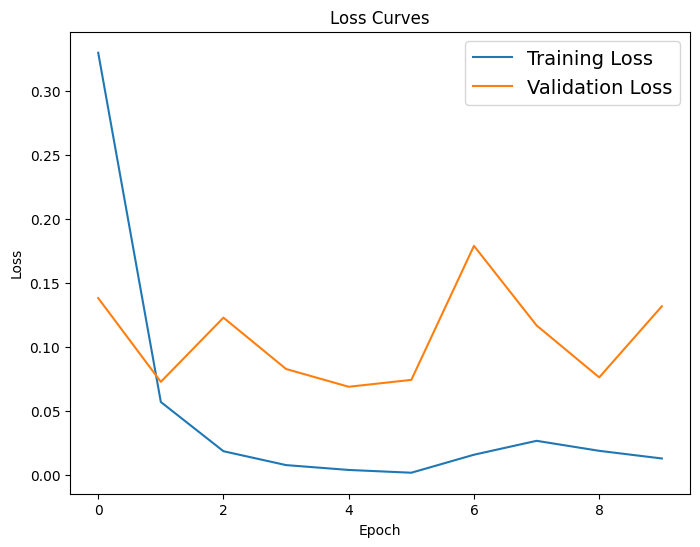

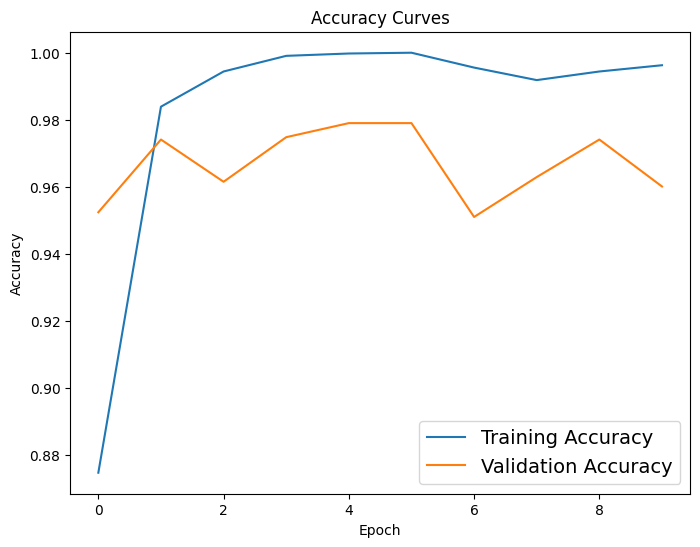

In [12]:
# Plot Learning Curves
plt.figure(figsize=[8,6])
plt.plot(train_losses_list, label='Training Loss')
plt.plot(val_losses_list, label='Validation Loss')
plt.legend(fontsize=14)
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=[8,6])
plt.plot(train_accs_list, label='Training Accuracy')
plt.plot(val_accs_list, label='Validation Accuracy')
plt.legend(fontsize=14)
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

C:\Users\lmynn\AppData\Local\Temp\ipykernel_24212\705153443.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.0712, Test Accuracy: 0.9825


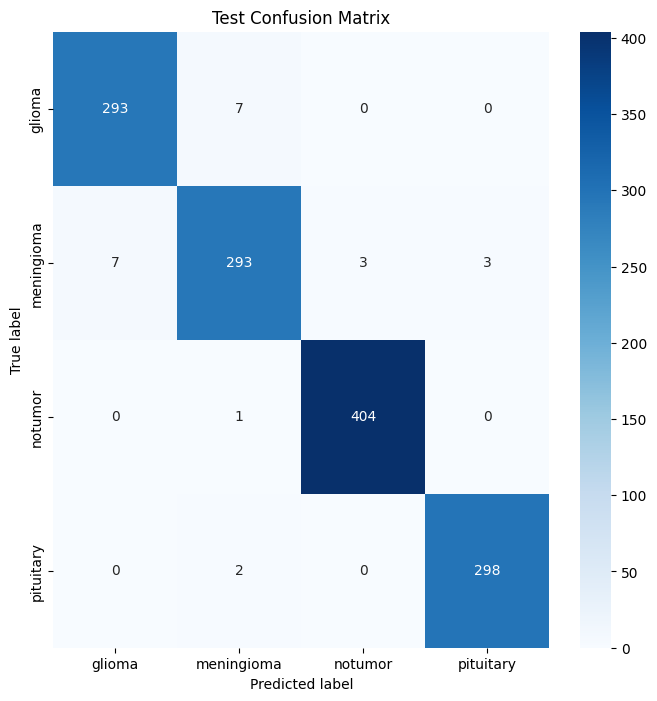

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       300
  meningioma       0.97      0.96      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [13]:
# Evaluation on Test Set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss, test_corrects, test_samples = 0.0, 0, 0
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == targets.data)
        test_samples += inputs.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_loss = test_loss / test_samples
test_acc = test_corrects.double() / test_samples
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Test Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(all_targets, all_preds, target_names=labels))
